# In Depth: Naive Bayes Classification

Naives Bayes models are extremely fast and simple.

Good to start with. It's the __baseline__.

Especially with :
- very high-dimensional datasets

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

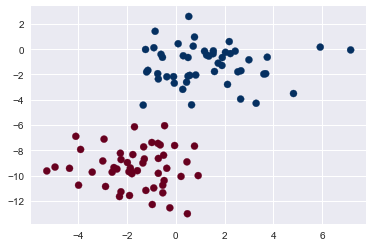

In [75]:
from sklearn.datasets import make_blobs # Generate isotropic Gaussian blobs for clustering.
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

## Bayesian Classification
In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

Now, we want a model by which we can compute $P({\rm features}~|~L_i)$ for each label.It specifies the hypothetical random process that generates the data.


If we make very naive assumptions about the generative model, we can find a rough approximation of the generative model for each class, and then proceed with the "naive" Bayesian classification.

## Gaussian Naives Bayes
The assumption is that __data from each label is drawn from a simple Gaussian distribution__. The data is described by a Gaussian distribution with __no covariance between dimensions__.

[(-15, 5), (-8, 8)]

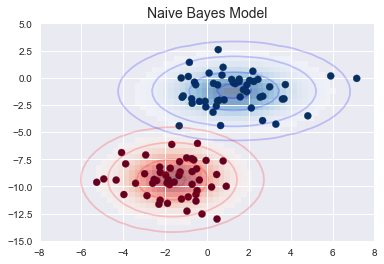

In [11]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03) # P < 0.03 is unvalid
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

This procedure is implemented in Scikit-Learn's ``sklearn.naive_bayes.GaussianNB`` estimator:

In [12]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Let's test it with new random points

In [78]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

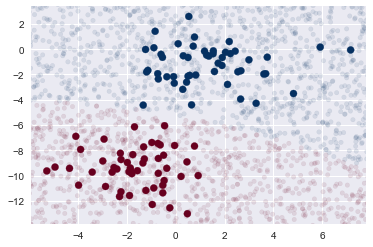

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

We can see the decision boundary ! 

An other nice feature is to be able to have label probabilities :

In [16]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

### Exercice : Do a 2D Gaussian Naive Bayes estimator

In [72]:
class gnb_model:
    
    def __init__(self):
        self.mean = []
        self.std = []
    
    def fit(self, X, y):
        labels = np.unique(y)
        for l in labels:
            mask = y == l
            mean, std = X[mask].mean(0), X[mask].std(0)
            self.mean.append(mean)
            self.std.append(std)
            
    def predict(self, new_X): # new_X shape (n_samples, n_features)
        mean = np.array(self.mean) # shape (n_labels, n_features)
        std = np.array(self.std) # shape (n_labels, n_features)
        probabilities = np.exp(-0.5 * (new_X[:, :, np.newaxis] - mean.T) ** 2 / std.T ** 2).prod(1)
        return np.argmax(probabilities, axis=1)

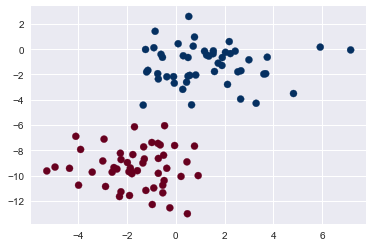

In [77]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');
model = gnb_model()
model.fit(X, y)

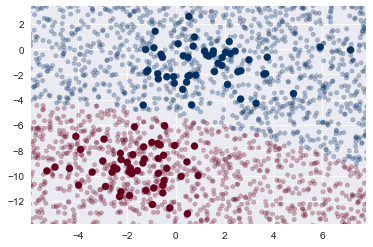

In [81]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.3)
plt.axis(lim);

## Multinomial Naive Bayes

from Wikipedia :
With a multinomial event model, samples (feature vectors) represent the frequencies with which certain events have been generated by a multinomial $( p_1 , … , p_n )$ where $p_i$ is the probability that event i occurs (or $K$ such multinomials in the multiclass case).

i.e. 
- The model fit the data finding a $p_1 , ... , p_n$ for each label.
- Then it's able to compute $P({\rm features }~|~L_i)$ for each label (using the probability mass function).
- Then it return the label with the greatest probability.

In [82]:
from sklearn.datasets import fetch_20newsgroups

categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(train.data, train.target)
labels = model.predict(test.data)

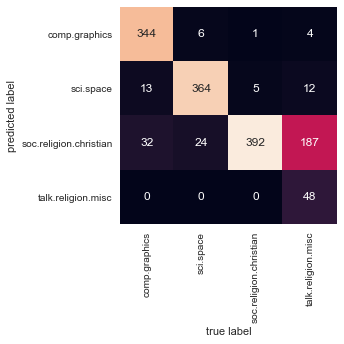

In [86]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## When to use Naive Bayes

Naives Bayes make simple assumptions on the data. They are generally less performant than more complicated models. 

But they have serveral avantages :

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters

These advantages mean a naive Bayesian classifier is often a good choice as an __initial baseline classification__. They works well when :
- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important
